In [64]:
from matplotlib import pyplot as plt
%matplotlib inline

In [65]:
def pp(s):
    print(s)
    return s + "\n"

# Datamodel for the flow network

In [66]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

import pfs_netflow.datamodel as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the catalogs, compute visibility ... 

In [67]:
BLOCKLENGTH = 450. # block exposure time in s, to simulate three consequtive exposures
#BLOCKLENGTH = 900. # block exposure time in s

In [68]:
# Define target lists.
fscience_targets = "../pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "../pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "../pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
from astropy.io import ascii

science_targets = ascii.read(fscience_targets)

cal_stars = ascii.read(fcal_stars)

sky_pos = ascii.read(fsky_pos)

# Conversion of column names, this should not be necessary anymore in future versions.
for t in [science_targets, cal_stars, sky_pos]:
    t['R'].name = 'RA'
    t['Dec'].name = 'DEC'
    t['Exposure'].name = 'EXP_TIME'

In [69]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{}'.format(t, p)
    
# limit targets to a smaller field of view
pointing_RA, pointing_DEC = 33.7035, -3.8455
DRMAX_SQ = .75**2
DRMAX_SQ = (2700./3600.)**2.

dra = (ra - pointing_RA)*cos(deg2rad(dec))
ddec = dec - pointing_DEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

In [70]:
# assign random priorities between 1 and 3 for the  science targets
from numpy import random
from numpy import array

random.seed(42)

N =  sum(ii_sci) 

newpri = array( random.uniform(1.,4., size=N) , dtype=int)
priorities = np.array(priorities)

priorities[ii_sci] = newpri
priorities = priorities.tolist()

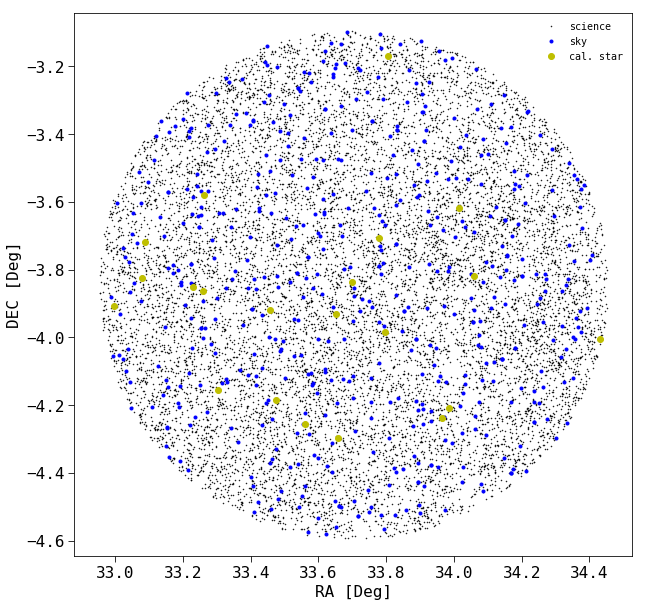

In [71]:
# plot targets on sky
f = plt.figure(figsize=[10,10])
plt.plot(np.array(ra)[ii_sci],np.array(dec)[ii_sci],'.', ms=1, label='science')
plt.plot(np.array(ra)[ii_sky],np.array(dec)[ii_sky],'b.' , label='sky')
plt.plot(np.array(ra)[ii_cal],np.array(dec)[ii_cal],'yo' , label='cal. star')
plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("RA [Deg]")
plt.ylabel("DEC [Deg]")

In [72]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = int(nrv)
    
print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

Required revisits [2]


In [73]:
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")

import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# Parse a target file and return the quantities of interest
ets_target_pos = radec2pos(ra,dec)

# get a list of targets, and a list of Cobras that can observe them
# keys contain object index
# values contain indices of cobras that can observe that object.
visibility_map = pyETS.getVis(ets_target_pos,ets_cobras)

In [74]:
# perform target assignment using the "draining" algorithm, and return the list
# of assigned targets and which cobras were used to observe them.
#res = pyETS.getObs(ets_target_pos,exp_times,priorities,ets_cobras,"draining_closest")

In [75]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format

# obtain cobra centers in old ETS dictionary style
cobras = {}
for i,c in enumerate(ets_cobras):
        x,y = (ets_cobras[c][0],ets_cobras[c][1])
        cobras["{:d}".format(i)] = [x,y]

# obtain target positions in old ETS dictionary style
targets = {}
for i,c in enumerate(ets_target_pos):
        x,y = np.real(c),np.imag(c)
        targets[ID[i]] = [float(x),float(y)]

# obtain visibilities in old ETS dictionary style
visibilities = {}     
for v in visibility_map:
    t = ID[v]
    cc = ["{:d}".format(c) for c in visibility_map[v]]
    visibilities[t] = cc
    

In [76]:
# Assign targetclass labels according to target type and priority
from numpy import unique

# Build dict that holds class descriptor string for each target.
# This is needed later because ETS does not preserve the order.
tclasses =   [class_dict[t] for t in visibilities]
print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in targets]

['cal_P1' 'sci_P1' 'sky_P1']


In [77]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = {}

    cnt = 0
    for v in visibilities:
        t = v
        cc = visibilities[v]

        for c in cc:
            if ivisibilities.has_key(c):
                ivisibilities[c].append(v)
            else:
                ivisibilities[c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [78]:
nsci_observable = 0
ncal_observable = 0
nsky_observable = 0

for tid,v in visibilities.iteritems():
    if len(v) > 0:
        if class_dict[tid][:3] == 'cal':
            ncal_observable += 1
        elif class_dict[tid][:3] == 'sky':
            nsky_observable += 1
        elif class_dict[tid][:3] == 'sci':
            nsci_observable += 1
        #break
            
            
print("{} targets positions in total.".format(sum(ii_sci) ))
print("{} cal. targets in total.".format(sum(ii_cal) ))
print("{} sky positions in total.".format(sum(ii_sky) ))
print("{} cobras have at least one target in reach.".format(len(ivisibilities)))
print("{} science targets\n{} calibration targets, \
and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  

12547 targets positions in total.
21 cal. targets in total.
557 sky positions in total.
2359 cobras have at least one target in reach.
8116 science targets
16 calibration targets, and 
353 sky positions are in reach of at least one cobra.


# run the ETS solver

In [79]:
def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: new.append(x)
    return new

In [80]:
import numpy as np
import time
    
ALGORITHM = "draining_closest"
ALGORITHM = "naive"
ALGORITHM = "draining"
ALGORITHM = "new"


NVISISTS = 10
ii = np.full_like(ID, True, dtype=bool)

# set priorities 
priorities2 = np.array(priorities)
priorities2[ii_sci] = 5
priorities2[~ii_sci] = 1
priorities2 = priorities2.tolist()

with open("ets_results_{}.txt".format(ALGORITHM), 'w') as f:
    s = "# algorithm: {}\n".format(ALGORITHM)
    s += "# total number of vistis: {}\n".format(NVISISTS)

    s += "# total number of observable science targets: {}\n".format(nsci_observable)
    s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    s += "# total number of observable sky positions: {}\n".format(nsky_observable)
    s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
    f.write(s)
    
    for v in range(NVISISTS):
        s= ""

        print("Visit {}".format(v))
        print(" Number of remaining targets to observe: {}".format(sum(ii)))

        #print(" Number of remaining cal. targets to observe: {}".format( sum( np.array(types)[ii] == "cal" ) ))
        #print(" Number of remaining sky targets to observe: {}".format( sum( np.array(types)[ii] == "sky" ) ))

        start_time = time.time()
        # perform target assignment using the "draining" algorithm, and return the list
        # of assigned targets and which cobras were used to observe them.
        #res = pyETS.getObs(fil(ets_target_pos,ii),fil(exp_times,ii),fil(priorities,ii),ets_cobras,"draining_closest")
        res = pyETS.getObs(ets_target_pos,exp_times,priorities2,ets_cobras,ALGORITHM)
        time_to_build = time.time() - start_time
        pp(" Time to solve: {:.4e} s".format(time_to_build))



        # figure which out of all potential science targets have been observed
        # and mark them as observed
        for r in res:
            if types[r] == 'sci':
                priorities2[r] = 15
                ii[r] = False

        # compute some statistics
        nsci_observed = sum(np.array(types)[ res.keys() ] == 'sci')
        ncal_observed = sum(np.array(types)[ res.keys() ] == 'cal')
        nsky_observed = sum(np.array(types)[ res.keys() ] == 'sky')
        print(" Observed {} science targets, {} calibration targets and {} sky positions"\
              .format(nsci_observed, ncal_observed, nsky_observed))
        N = len( res.items() )
        #print(" Observed {} targets.".format(N))
        nsci_observed_total = sum(ii_sci * ~ii)
        print(" Observed {} science targets in total.".format(nsci_observed_total))
        print("")
        
        s += "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(v, nsci_observed, ncal_observed, nsky_observed, nsci_observed_total)
        f.write(s)

#np.any( np.array(types)[ res.keys() ] == 'cal' )

Visit 0
 Number of remaining targets to observe: 13125
 Time to solve: 2.5777e-02 s
 Observed 2019 science targets, 16 calibration targets and 322 sky positions
 Observed 2019 science targets in total.

Visit 1
 Number of remaining targets to observe: 11106
 Time to solve: 2.2911e-02 s
 Observed 2023 science targets, 16 calibration targets and 316 sky positions
 Observed 3881 science targets in total.

Visit 2
 Number of remaining targets to observe: 9244
 Time to solve: 2.2092e-02 s
 Observed 2029 science targets, 14 calibration targets and 310 sky positions
 Observed 5389 science targets in total.

Visit 3
 Number of remaining targets to observe: 7736
 Time to solve: 2.3261e-02 s
 Observed 2031 science targets, 16 calibration targets and 309 sky positions
 Observed 6394 science targets in total.

Visit 4
 Number of remaining targets to observe: 6731
 Time to solve: 2.2348e-02 s
 Observed 2025 science targets, 16 calibration targets and 316 sky positions
 Observed 6892 science targets

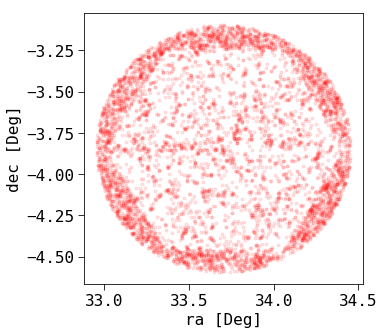

In [81]:
# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii), fil(dec,ii), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

# Execute netflow

In [82]:
from numpy import inf

# Here we define the costs

cost_dict = {}
# For each target class we define the cost of non-observation
# and non-completion as a two-tuple. The cost of non-completion 
# is typically larger as partial completion of objects shoudl be avoided.
cost_dict['sci_P1'] = (1000.,1e9)
cost_dict['sci_P2'] = (100.,1e9)
cost_dict['sci_P3'] = (10.,1e9)

# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P1'] = 10000.
cost_dict['sky_P1'] = 10000.

# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P1'] = inf
supply_dict['sci_P2'] = inf
supply_dict['sci_P3'] = inf

# need one calibration star per exposure
supply_dict['cal_P1'] = 16 # inf = try to get as amny as  possible
# need one sky positions per exposure
supply_dict['sky_P1'] = 322 # inf = try to get as amny as  possible



In [87]:
from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

NVISITS = 10
COBRAS = []

# intermediate example
RMAX = 50.
CENTER = [-5.,90.]
name="intermediate"


# intermediate example
RMAX = 60.
CENTER = [0.,0.]
name="intermediate"

# good minimal example
RMAX = 10.
CENTER = [0.,0.]
name="minimal"

# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"



print("Creating graph ...")
g = buildSurveyPlan(cobras, targets, nreqvisits, visibilities, class_dict, cost_dict, supply_dict, NVISITS, \
                    RMAX, CENTER, COBRAS = COBRAS)
print("Done.")

for c in g.sciTargetClasses:
    
    nsci = 0
    nsci_reachable = 0
    for t in g.sciTargetClasses[c].targets.itervalues():
        if t.outarcs != []:
            nsci += 1
            nsci_reachable += 1
        
    print("Number of targets in {} is {}.".format(c, nsci ) )
    print("Number of observable targets in {} is {}.".format(c, nsci_reachable ) )
    

    
ncal = 0
ncal_reachable = 0
for t in g.calTargetClasses['TClass_cal_P1_v0'].targets.itervalues():
    if t.outarcs != []:
        ncal += 1
        ncal_reachable += 1
print("Number of calibration stars: {}".format(ncal) )
print("Number of observable calibration stars: {}".format( ncal_reachable )) 
            

nsky = 0
nsky_reachable = 0
for t in g.calTargetClasses['TClass_sky_P1_v0'].targets.itervalues():
    if t. outarcs != []:
        nsky += 1
        nsky_reachable += 1
print("Number of sky positions: {}".format(nsky) )
print("Number of observable sky positions: {}".format(nsky_reachable) )

if RMAX == 10. or False:
    plotSurveyPlan(g)

Creating graph ...
buildSurveyPlan 
Done.
Number of targets in TClass_sci_P1 is 12547.
Number of observable targets in TClass_sci_P1 is 12547.
Number of calibration stars: 16
Number of observable calibration stars: 16
Number of sky positions: 353
Number of observable sky positions: 353


In [88]:
from pfs_netflow.lp import buildLPProblem, computeStats, solve
from pulp import LpStatus, value


def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])


maxSeconds=600.

    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(NCalTargets/NVISITS))
summary += pp(" {} cobras".format(NCobras))
summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g)
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()
status = solve(prob, maxSeconds=maxSeconds)
time_to_solve = time.time() - start_time
summary += pp("Solve status is {}.".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats.cost) ) )
summary += pp("{} out of {} science targets get observed.".format(int(stats.NSciObs),NSciTargets))
summary += pp("For {} out of these all required exposures got allocated.".format(stats.NSciComplete))
summary += pp("{} targets get sent down the overflow arc.".format(stats.Noverflow))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats.Ncobras_used, NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats.Ncobras_fully_used))

setflows(g,flows)

NVISITS = 10
Searching optimal strategy to observe in 
 10 visits
 12547 science targets
 578 calib. targets
 2394 cobras
Will stop in any case after 600.0 s.
num nodes: 170153
num edges: 288787
Building LP problem ...
Building cost equation ...
 Time to completion: 17.60 s
Time to build model: 1.7649e+01 s
Solving LP problem ...
Solve status is Optimal.
Time to solve: 7.2193e+01 s
Value of cost function = 5476000.0
7071 out of 12547 science targets get observed.
For 7071 out of these all required exposures got allocated.
5476.0 targets get sent down the overflow arc.
2359 out of 2394 cobras observed a target in one or more exposures.
875 cobras observed a target in all exposures.


In [43]:
nsci_observed_total = 0


with open("nwf_results_nvisits{}.txt".format(NVISITS), 'w') as f:
    s  = "# algorithm: {}\n".format("netflow")
    s += "# total number of vistis: {}\n".format(NVISISTS)

    s += "# total number of observable science targets: {}\n".format(nsci_observable)
    s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    s += "# total number of observable sky positions: {}\n".format(nsky_observable)
    s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
    f.write(s)

    for visit in g.visits:
        print("Visit {}".format(visit))
        nsci = 0
        ncal = 0
        nsky = 0
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode

            if a.flow > 0.:
                #print n1,n2, a.flow, n2.visit
                #print type(n2) == dm.CobraVisit , n2.visit == visit , type(n1) == dm.TargetVisit
                #break
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.TargetVisit:
                        nsci += 1
                        nsci_observed_total += 1
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.CalTarget:
                        try:
                            if class_dict[ n1.id[2:-3] ][:3] == "sky":
                                nsky += 1

                            else:
                                ncal += 1 
                        except:
                            pass

        s = "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(visit, nsci, ncal, nsky, nsci_observed_total)
        f.write(s)
        
        print("Observed {} science targets, {} calibration targets and {} sky positions.".format(nsci, ncal, nsky))
        print(" Observed {} science targets in total.".format(nsci_observed_total))
        print("")


Visit 0
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 1 science targets in total.

Visit 1
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 2 science targets in total.

Visit 2
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 3 science targets in total.

Visit 3
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 4 science targets in total.

Visit 4
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 5 science targets in total.

Visit 5
Observed 1 science targets, 0 calibration targets and 0 sky positions.
 Observed 6 science targets in total.



In [ ]:
nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))


In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10.txt")
nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

In [ ]:
f = plt.figure(figsize=[8,8])


for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)
l = plt.legend()
l.draw_frame(False)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

#nvisits = 10
#plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8500])

# New & auxiliary stuff

In [ ]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

In [ ]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [ ]:
!open .